In [1]:
import os
import h5py
import numpy as np
import torch
import torchani
import ase
from ase import Atom
from ase import Atoms
from ase import units
from ase.io import read, write
import matplotlib
from matplotlib import pyplot as plt
from ase.md import langevin
from ase.md import verlet
from ase.optimize import BFGS

device = torch.device('cpu')

home = os.getcwd()

C:\Users\AMJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mol = []
def printenergy(a=mol):
    epot = a.get_potential_energy()
    ekin = a.get_kinetic_energy()
    return epot + ekin

In [3]:
network_folders = []

def atomic(linear=[(384,128), (128,128), (128,64), (64,1)]):
    model = torch.nn.Sequential(
        torch.nn.Linear(*linear[0]),
        torch.nn.CELU(0.1),
        torch.nn.Linear(*linear[1]),
        torch.nn.CELU(0.1),
        torch.nn.Linear(*linear[2]),
        torch.nn.CELU(0.1),
        torch.nn.Linear(*linear[3])
    )
    return model
nn = torchani.ANIModel([atomic(v) for v in (
[(384,160), (160,128), (128,96), (96,1)],
[(384,144), (144,112), (112,96), (96,1)],
[(384,128), (128,112), (112,96), (96,1)],
[(384,128), (128,112), (112,96), (96,1)]
)])

network_folders = ['./best.pt']
path = './train/eval/'
const_file = path + 'rHCNO-5.2R_16-3.5A_a4-8.params'
sae_file = path + 'sae_linfit_CAS.dat'

consts = torchani.neurochem.Constants(const_file)
aev_computer = torchani.AEVComputer(**consts)
energy_shifter = torchani.neurochem.load_sae(sae_file)

In [4]:
def printxyz(a=mol):
    """Function to print out xyz coordinates"""
    check_out=os.getcwd() + '/output'
    os.chdir(check_out)
    i=0
    file_name = str(i) + '_checkpoint.pdb'
    file_name = str(file_name)
    while (os.path.isfile(file_name)):
        i=i+1
        file_name = str(i)+'_checkpoint.pdb'
        file_name = str(file_name)
    checkpoint_out = str(i) +  '_checkpoint.pdb'
    write(str(checkpoint_out), mol)
    os.chdir('..')

In [5]:
with h5py.File('./transfer/energy2.h5', 'r') as dataset:
    coordinates = dataset['firstlayer']['secondlayer']['coordinates']
    coordinates = dataset['firstlayer']['secondlayer']['coordinates'][:len(coordinates)]
    energies = dataset['firstlayer']['secondlayer']['energies'][:len(coordinates)]

In [6]:
print(coordinates[0])
print(str(float(coordinates[0][0][2])))
cr = coordinates

[[-0.6265  0.1377  0.2987]
 [ 0.6354 -0.1876 -0.359 ]
 [-1.2671  0.8964 -0.155 ]
 [-0.9622 -0.8662 -0.1374]
 [ 0.9711  0.8163  0.077 ]
 [ 1.276  -0.9463  0.0945]]
0.2987


In [7]:
evaluated_energies = []

for i in range(1):
    for x in range(1):
        #mol = [ Atom('C', (  0.000000,    0.000000,    0.669100)),
        #Atom('C', (  -0.000000,    0.000000,   -0.669100)),
        #Atom('H', (  -0.000000,    0.914900,    1.234800)),
        #Atom('H', (  -0.000000,   -0.914900,    1.234800)),
        #Atom('H', (  -0.000000,    0.914900,   -1.234800)),
        #Atom('H', (  -0.000000,   -0.914900,   -1.234800)) ]
        mol = [Atom('C', (cr[0][0][0], cr[0][0][1], cr[0][0][2])),
               Atom('C', (  cr[0][1][0], cr[0][1][1], cr[0][1][2])),
               Atom('H', (  cr[0][2][0], cr[0][2][1], cr[0][2][2])),
               Atom('H', (  cr[0][3][0], cr[0][3][1], cr[0][3][2]  )),
               Atom('H', (  cr[0][4][0], cr[0][4][1], cr[0][4][2]  )),
               Atom('H', (  cr[0][5][0], cr[0][5][1], cr[0][5][2]  )) ]

        mol = Atoms(mol)
        personal_directory = os.getcwd()
        network = network_folders
        calculator = torchani.ase.Calculator(personal_directory, consts.species, aev_computer, network, nn, energy_shifter, device)

        mol.set_calculator(calculator)
        energy = float(str(printenergy(a=mol))) * (1/units.Hartree) * 627.509474062112 # Hartree to kcal/mol conversion
        print(energy)
        try:
            os.mkdir('./output/')
        except:
            pass
        opt = BFGS(mol)
        #opt.run(fmax=0.1)
        verletsim = verlet.VelocityVerlet(mol, 0.1 * units.fs)
        verletsim.attach(printxyz, interval=10)
        verletsim.run(5000)

        #langevinsim = langevin.Langevin(mol, 0.1 * units.fs, temperature =0.5 * units.kB, friction=0.01)
        #langevinsim.attach(printxyz, interval=10)
        #langevinsim.run(5000)

-48781.88324349252


C:\Users\AMJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchani\ase.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  cell = torch.tensor(self.atoms.get_cell(complete=True),


In [8]:
os.chdir('./output/')
with open('cat_output.pdb', 'w') as f:
    for i in range(500):
        with open(str(i) + '_checkpoint.pdb', 'r') as f1:
            lines = f1.readlines()
            for line in lines:
                f.write(line)

os.chdir('../')

In [9]:

evaluated_energies = []
for i in range(500):
    with open('./output/' + str(i) + '_checkpoint.pdb', 'r') as f1:
        atoms=[]
        lines = f1.readlines()
        for x in range(1, len(lines)-1):
            atom = lines[x].split()
            atom = [float(atom[5]), float(atom[6]), float(atom[7])]
            atoms.append(atom)
        c = atoms
        mol = [ Atom('C', (c[0][0],  c[0][1], c[0][2])),
        Atom('C', (c[1][0],  c[1][1], c[1][2])),
        Atom('H', (c[2][0],  c[2][1], c[2][2])),
        Atom('H', (c[3][0],  c[3][1], c[3][2])),
        Atom('H', (c[4][0],  c[4][1], c[4][2])),
        Atom('H', (c[5][0],  c[5][1], c[5][2])) ]
        mol = Atoms(mol)
        personal_directory = os.getcwd()
        network = network_folders
        calculator = torchani.ase.Calculator(personal_directory, consts.species, aev_computer, network, nn, energy_shifter, device)
        mol.set_calculator(calculator)
        energy = float(str(printenergy(a=mol))) * (1/units.Hartree) * 627.509474062112
        evaluated_energies.append(energy)
        
with open('md_energies.txt', 'w') as f:
    for i in range(len(evaluated_energies)):
        f.write(str(evaluated_energies[i]))
        f.write('\n')

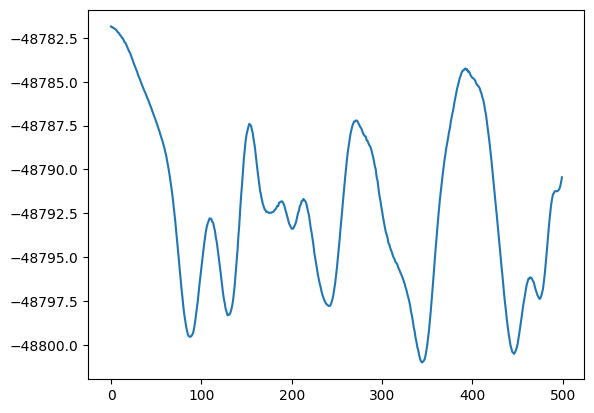

<Figure size 640x480 with 0 Axes>

In [10]:
x_axis, y_axis = [], []
for i in range(len(evaluated_energies)):
    x_axis.append(int(i))
    y_axis.append(round(float(evaluated_energies[i]), 11))
line1 = plt.plot(x_axis, y_axis)
plt.savefig('./md_energies.png')
plt.show()
plt.clf() 


os.chdir('./output/')
with open('cat_output.pdb', 'w') as f:
    for i in range(500):
        with open(str(i) + '_checkpoint.pdb', 'r') as f1:
        lines = f1.readlines()
        for line in lines:
            f.write(line)

os.chdir('../')